In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

np.random.seed(0)

# Settings
P0 = 3.8
Pdec = 1000
tmax = 20
amp = [3.0, 1.0, 0.33]
der = [1.0, 4.0, 0.5]
nt = [75, 100, 50]


In [9]:
def func_deriv(t, p0, amp, der):
    return amp * np.sin(2 * np.pi * t / p0) + der * np.cos(2 * np.pi * t / p0) 

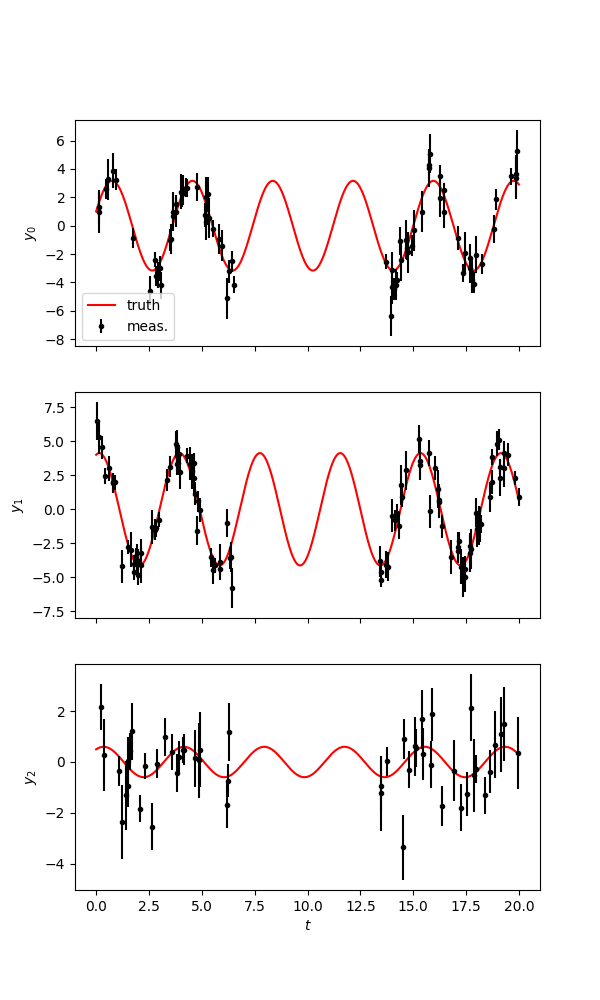

In [10]:
# True signal
tsmooth = np.linspace(0, tmax, 2000)
Ysignal = [
  func_deriv(tsmooth, P0, ak, dk)
  for ak, dk in zip(amp, der)
]


# Generate observations calendars
T = [
  np.sort(
  np.concatenate((np.random.uniform(0, tmax / 3,
  ntk // 2), np.random.uniform(2 * tmax / 3, tmax, (ntk + 1) // 2))))
  for ntk in nt
]

# Generate measurements with white noise
Yerr = [np.random.uniform(0.5, 1.5, ntk) for ntk in nt]
Y = [ func_deriv(T[k], P0, amp[k], der[k]) +
  np.random.normal(0, Yerr[k]) for k in range(3)
]

# Plot
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()

In [21]:
## test 

test = []
yerr = []
for k in range(0,3):
    test.append(func_deriv(T[k], P0, amp[k], der[k]))
for k in range(0,3):
    yerr.append(test[k]**2)
print(yerr)

[array([2.54581442e+00, 2.68421015e+00, 7.98110023e+00, 9.18992558e+00,
       9.97009927e+00, 8.94286018e+00, 9.26217175e-02, 9.73372641e+00,
       9.67865603e+00, 9.23964835e+00, 8.23982600e+00, 6.45686797e+00,
       5.88617973e+00, 4.30615748e-01, 1.71554343e-01, 2.01327138e-02,
       7.76066977e-02, 8.74426077e-01, 8.98827639e-01, 3.98223679e+00,
       5.00379104e+00, 5.61290231e+00, 7.88153315e+00, 8.39311582e+00,
       8.81520409e+00, 2.89883530e+00, 2.51477119e+00, 2.29134975e+00,
       1.34658816e+00, 8.38615446e-01, 5.62210814e-02, 2.19193733e+00,
       4.41838010e+00, 7.94207404e+00, 9.33604451e+00, 9.97376575e+00,
       9.87146955e+00, 7.44386506e+00, 9.81985426e+00, 9.84808036e+00,
       9.95235997e+00, 9.99482543e+00, 9.49244055e+00, 8.95437874e+00,
       7.19268932e+00, 6.95806657e+00, 3.16747363e+00, 1.98883373e+00,
       1.85800650e+00, 4.94669288e-02, 7.47309083e-03, 4.27144091e+00,
       8.67462801e+00, 8.97259348e+00, 9.28330839e+00, 7.85170085e+00,
     

In [11]:
from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Merge all 3 time series
t_full, y_full, yerr_full, series_index = cov.merge_series(T, Y, Yerr)


In [12]:
print(t_full)
print(y_full)

[ 0.03130317  0.12526534  0.13405031  0.13478932  0.21225953  0.26125195
  0.38686107  0.42764998  0.47357372  0.580862    0.62627007  0.78849617
  0.79151813  0.80131041  0.87865242  0.95568858  1.09796104  1.22127575
  1.24128671  1.39895833  1.48721088  1.49283125  1.51609752  1.58595214
  1.65835429  1.69570988  1.76370408  1.76926327  1.80005315  1.88537975
  1.92937395  1.97426798  1.98291301  2.0796333   2.11988786  2.12379302
  2.30234454  2.55627679  2.64337161  2.65480708  2.7617533   2.76441293
  2.82436533  2.82570032  2.89611084  2.91724808  2.98083586  3.04100221
  3.07652908  3.26972539  3.34216255  3.47898881  3.48832036  3.52596613
  3.57088535  3.63255455  3.65875669  3.77734303  3.78696374  3.78955966
  3.81501271  3.8396433   3.8410489   3.84819059  3.87515248  3.91008623
  3.93273318  3.94694621  4.01842251  4.08063815  4.09310637  4.11756998
  4.14318934  4.26614014  4.29326799  4.30596075  4.44940253  4.51877691
  4.6164808   4.61687727  4.66319517  4.69609601  4

In [32]:
# Initialize the S+LEAF model
import time
time0 = time.time()
D = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 2., 1000.0, 0.35), series_index,
  np.ones(3), np.zeros(3)))
time1 = time.time()
print(time1-time0)



0.011187076568603516


In [33]:
# Fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.param
# List of parameters to fit
param = D.param[1:]
# The amplitude of the kernel is fixed at 1 (not fitted),
# since it would be degenerated with the amplitudes alpha, \beta.


bounds = np.zeros([len(param),2])
bounds[4:,0] = -10
bounds[:,1] = 220
bounds[0,:] = [1.6, 10.2]
bounds[1,:] = [500, 2000]
bounds[2,:] = [0, 0.50]

y = y_full

# Define the function to minimize
def negloglike(x, y, D):
  D.set_param(x, param)
  nll = -D.loglike(y)
  # gradient
  nll_grad = -D.loglike_grad()[1][1:]
  return (nll, nll_grad)

def pyde_function(x):
  #print(x)
  sel = (x < bounds[:,0]) | (x>bounds[:,1])
  if np.sum(sel) > 0:
    return -np.inf
  D.set_param(x, param)
  ll = D.loglike(y)
  return ll


from pyde.de import DiffEvol
de = DiffEvol(pyde_function, bounds, 50, maximize=True)
res = de.optimize(ngen=510000)




In [34]:
print(bounds)
print(res)
print(param)




[[ 1.60e+00  1.02e+01]
 [ 5.00e+02  2.00e+03]
 [ 0.00e+00  5.00e-01]
 [ 0.00e+00  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]]
(array([ 7.61133330e+00,  1.72004611e+03,  9.07436398e-03,  1.82193335e+00,
       -4.72104248e-01, -1.17866145e-02,  1.00809063e+00,  1.77643947e+00,
        2.83210340e-01]), 321.4754634757028)
['GP.P', 'GP.rho', 'GP.eta', 'GP.alpha_0', 'GP.alpha_1', 'GP.alpha_2', 'GP.beta_0', 'GP.beta_1', 'GP.beta_2']


[ 3.80442661e+00  1.91094124e+03  4.99750889e-01  2.33671764e+00
  1.93468884e+00  3.46317865e-01 -2.45944548e-01  1.24082683e+00
  1.73335488e-01]


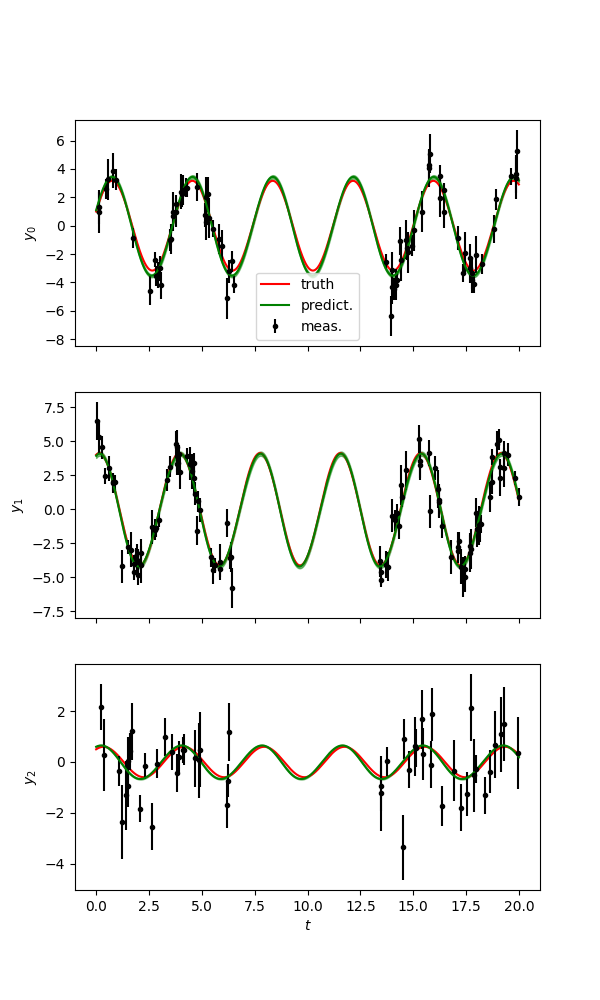

In [17]:


# Fit
#xbest, _, _ = fmin_l_bfgs_b(negloglike, D.get_param(param), args=(y_full, D))

xbest = res[0]
print(xbest)
# Use S+LEAF to predict the missing data

D.set_param(xbest, param)
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  # Predict time series k
  D.kernel['GP'].set_conditional_coef(series_id=k)
  mu, var = D.conditional(y_full, tsmooth, calc_cov='diag')

  # Plot
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.fill_between(tsmooth,
    mu - np.sqrt(var),
    mu + np.sqrt(var),
    color='g',
    alpha=0.5)
  ax.plot(tsmooth, mu, 'g', label='predict.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()
plt.show()